# Training custom CNN models

- [Custom model, case1](#sec1)
- [Custom model, case2](#sec2)

In [12]:
import copy
import matplotlib.pyplot as plt
import mototaxi_utils as mutils
import numpy
import PIL
import torch
import torchvision

from torchvision.models import MobileNet_V2_Weights


<a id='sec1'></a>
## Customizing model MobileNetV2: case1 

As mentioned on the previous notebook, MobileNetV2 does not recognize mototaxis (its best guess was a **stopwatch**). Here we reuse most of the MobileNet architecture (158 layers) and modify the last layer to create a 1-neuron classifier: `new_classifier`, which is a fully-connected layer with 1000 inputs and 1 output. In case1 only the parameters of this layer will be trained, with parameters for all other layers kept frozen. The snippet below illustrates customizing this model. See full source at `pytorch_mototaxi.py::transfer_learning_case1()`.

In [ ]:
model = torchvision.models.mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)

for param in model.parameters():
    param.requires_grad = False

new_classifier = torch.nn.Sequential(torch.nn.Dropout(p=0.2, inplace=False),
                                     torch.nn.Linear(in_features=model.classifier[1].in_features,
                                                     out_features=1, bias=True)
                                     )
model.classifier = new_classifier

<a id='sec2'></a>
## Training of model1 on real photos

In [4]:
%run ../pytorch_mototaxi.py case1

Training: Case1 (name=01_05_24_case1_sckxcduv.pth, num_samples_per_epoch=200; batch_size=32;
                 num_epochs=20, learning rate: initial=0.001, step_size=1, gamma=1.0 )
Epoch #00 -->Training Loss: 0.743 Acc.: 0.460; Validation Loss: 0.644 Acc.: 0.485
Epoch #01 -->Training Loss: 0.642 Acc.: 0.600; Validation Loss: 0.584 Acc.: 0.550
Epoch #02 -->Training Loss: 0.588 Acc.: 0.555; Validation Loss: 0.543 Acc.: 0.615
Epoch #03 -->Training Loss: 0.520 Acc.: 0.730; Validation Loss: 0.512 Acc.: 0.715
Epoch #04 -->Training Loss: 0.491 Acc.: 0.715; Validation Loss: 0.481 Acc.: 0.725
Epoch #05 -->Training Loss: 0.473 Acc.: 0.700; Validation Loss: 0.464 Acc.: 0.815
Epoch #06 -->Training Loss: 0.474 Acc.: 0.810; Validation Loss: 0.445 Acc.: 0.800
Epoch #07 -->Training Loss: 0.441 Acc.: 0.735; Validation Loss: 0.444 Acc.: 0.720
Epoch #08 -->Training Loss: 0.394 Acc.: 0.775; Validation Loss: 0.412 Acc.: 0.845
Epoch #09 -->Training Loss: 0.396 Acc.: 0.835; Validation Loss: 0.446 Acc.: 0.850


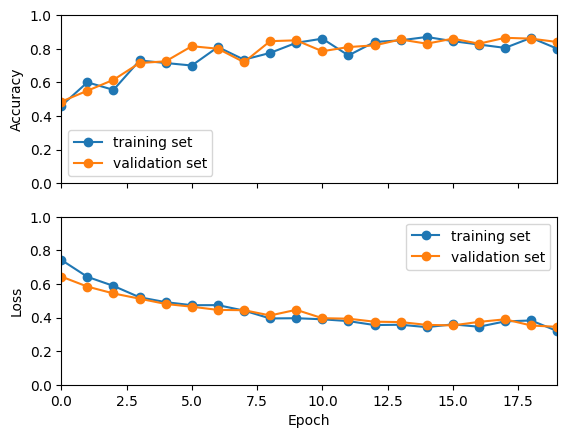

In [6]:
hyperparams_filename = "../models/01_05_24_case1_sckxcduv.hparams"
hyperparams = torch.load(hyperparams_filename)
num_epochs = hyperparams['num_epochs']
history = hyperparams['history']
mutils.plot_history(history, num_epochs)


<a id='sec3'></a>

## Training of model2 on real photos

As seen above **model1** achieves ~80 % of accuracy. Now we further fine-tune the model by unfreezing some deeper layers for training. The snippet below illustrates this customization, see full source at `pytorch_mototaxi.py::transfer_learning_case2()`.

We start **model2** from a `starting_model`, which is as a deepcopy of our previously trained **model1** (both its architecture and parameters saved in `../models/01_05_24_case1_sckxcduv.pth`). Then, we loop over all the layers, `model.parameters()`, and manually freeze all parameters belonging to the first 126 layers using `requires_grad = False`. All other layers, from 127 to 158, including our `new_classifier`, will be trained. 

After training, we see that **model2** achieves ~95% accuracy. 

In [ ]:
def transfer_learning_case2(data_loaders, hyperparams, starting_model):
    model = copy.deepcopy(starting_model)
    layer_cutoff = 126  #total number of layers 158 layers
    for i, param in enumerate(model.parameters()):
        if i < layer_cutoff:
            param.requires_grad = False
        else:
            param.requires_grad = True

Then we run the training script:

In [7]:
%run ../pytorch_mototaxi.py case2

Training: Case2 (name=01_05_24_case2_xdawhmcc.pth, num_samples_per_epoch=200; batch_size=64;
                 num_epochs=20, learning rate: initial=0.0001, step_size=4, gamma=1.0 )
Epoch #00 -->Training Loss: 0.362 Acc.: 0.815; Validation Loss: 0.309 Acc.: 0.885
Epoch #01 -->Training Loss: 0.229 Acc.: 0.915; Validation Loss: 0.285 Acc.: 0.875
Epoch #02 -->Training Loss: 0.213 Acc.: 0.910; Validation Loss: 0.277 Acc.: 0.875
Epoch #03 -->Training Loss: 0.199 Acc.: 0.915; Validation Loss: 0.293 Acc.: 0.860
Epoch #04 -->Training Loss: 0.151 Acc.: 0.955; Validation Loss: 0.276 Acc.: 0.880
Epoch #05 -->Training Loss: 0.152 Acc.: 0.960; Validation Loss: 0.257 Acc.: 0.905
Epoch #06 -->Training Loss: 0.165 Acc.: 0.955; Validation Loss: 0.242 Acc.: 0.885
Epoch #07 -->Training Loss: 0.099 Acc.: 0.970; Validation Loss: 0.268 Acc.: 0.880
Epoch #08 -->Training Loss: 0.132 Acc.: 0.965; Validation Loss: 0.243 Acc.: 0.890
Epoch #09 -->Training Loss: 0.111 Acc.: 0.960; Validation Loss: 0.198 Acc.: 0.920

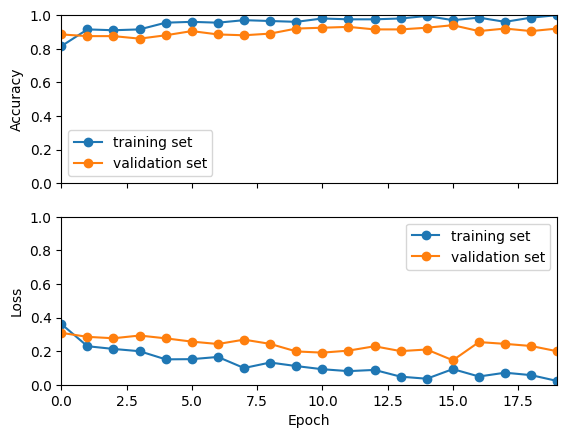

In [11]:
hyperparams_filename = "../models/01_05_24_case2_xdawhmcc.hparams"
hyperparams = torch.load(hyperparams_filename)
num_epochs = hyperparams['num_epochs']
history = hyperparams['history']
mutils.plot_history(history, num_epochs)
